In [42]:
%load_ext autoreload
%autoreload 2

import seaborn # icefire 
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy

# package settings
np.random.seed(0)

import perc
import perc.vis as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [43]:
### Data Constants
DT = 0.02
TEST_PERC = 0.7
TN = 50
FCAST_LEN = 10_000
u0 = np.array([0.1,1.0,5.0])

### RC Configuration
RC_CONFIG = {
    'Nu': -1, # will fill in later
    'Nr': 20,
    'alpha': 0.6,
    'beta': 8e-8,
    'rho_A': 0.1,
    'lambda_max': 0.8,
    'sigma': 0.084,
    'bias': 1.6,
    'spinup': 5,
    'f': np.tanh,
}

# Load data 

U_train shape: (3, 750)
U_test shape: (3, 1750)


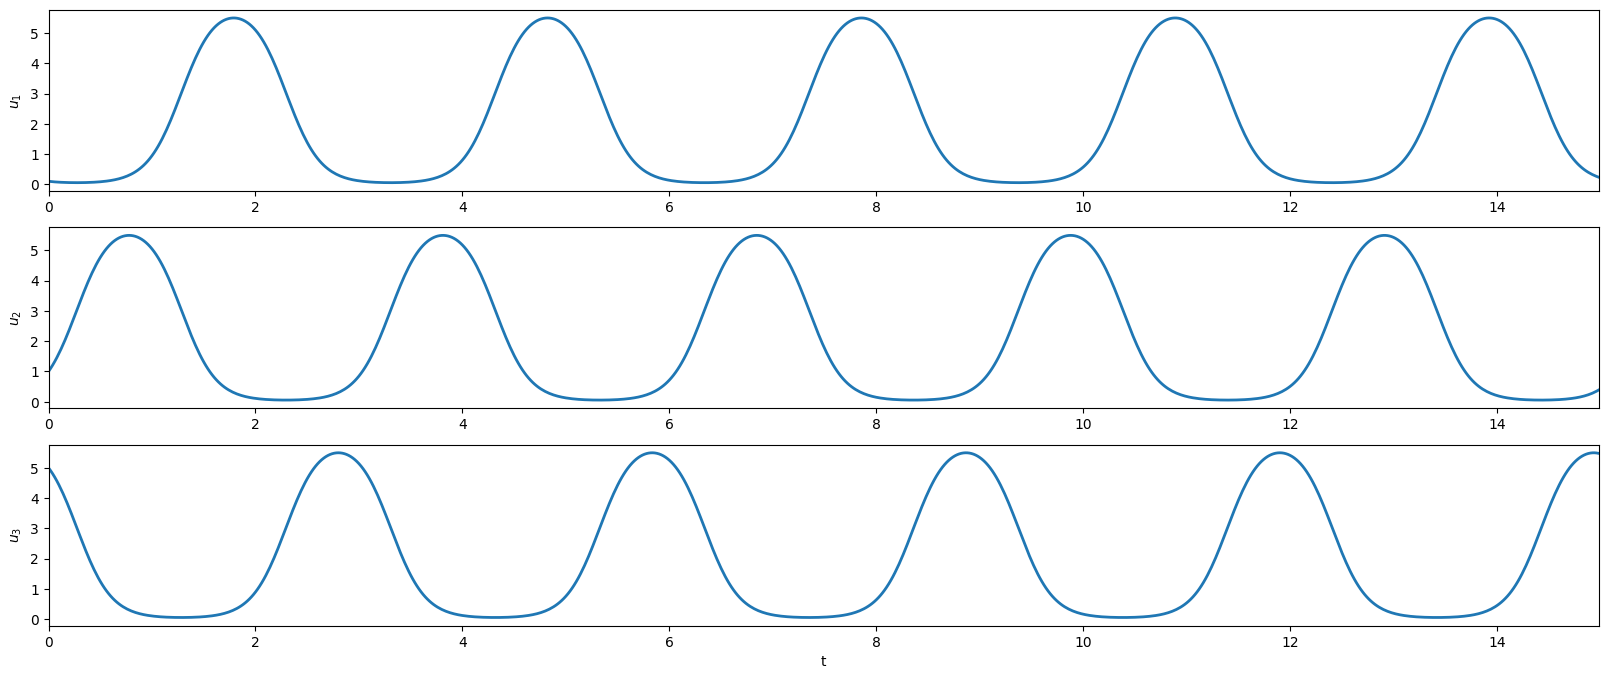

In [44]:
### Obtain + process data

# integrate lotka volterra
def f(t,u):
    x,y,z = u
    xdot = x*(y-z)
    ydot = y*(z-x)
    zdot = z*(x-y)
    return np.array([xdot, ydot, zdot]) 

ts = np.arange(0,TN,DT)
sol = scipy.integrate.solve_ivp(f, t_span=(0,TN),
                                y0=u0,
                                dense_output=True,
                                method='DOP853',
                                rtol=1e-12,
                                atol=1e-12)
U = sol.sol(ts)
t = ts
RC_CONFIG['Nu'] = U.shape[0]  #as promised 

# linear constraints
C = np.array([[1,1,1]])
d = np.array([[np.sum(u0)]])

# train-test split
split_idx = int((1-TEST_PERC) * U.shape[1])
U_train = U[:, :split_idx]
U_test = U[:, split_idx:]
t_train = t[:split_idx] 
t_test = np.arange(U_test.shape[1]) * DT  # start from 0
print(f"U_train shape: {U_train.shape}")
print(f"U_test shape: {U_test.shape}")

# calc error on test set
C_err_utest = (C@U_test - d).reshape(-1)

# plot
vis.plot_time_series(U_train,
                     t_train,
                     labels=[r'$u_1$', r'$u_2$', r'$u_3$'],)

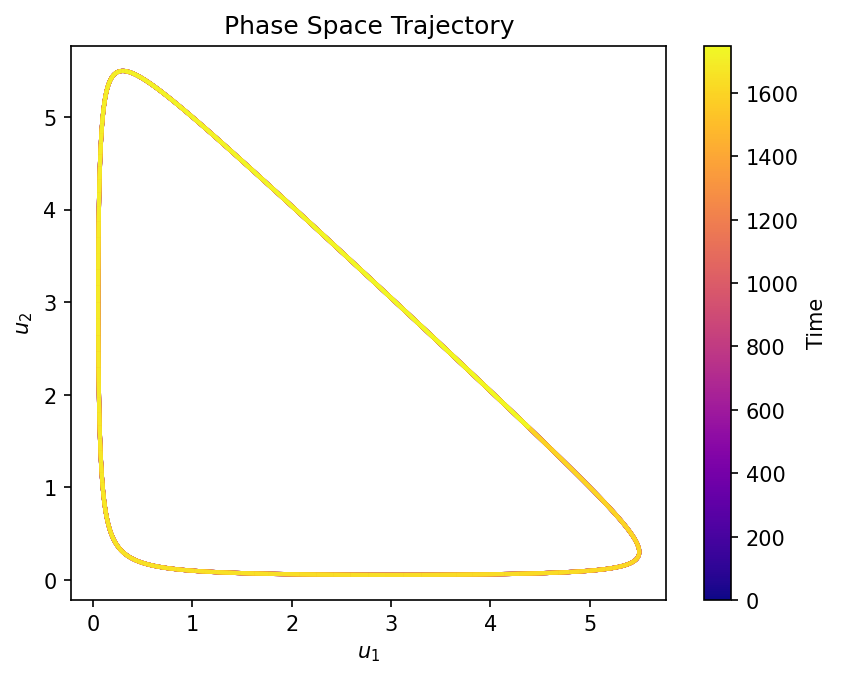

In [45]:
vis.plot_phase_space(U_test[:-1], labels=[r'$u_1$', r'$u_2$'],)

# Train Unconstrained RC

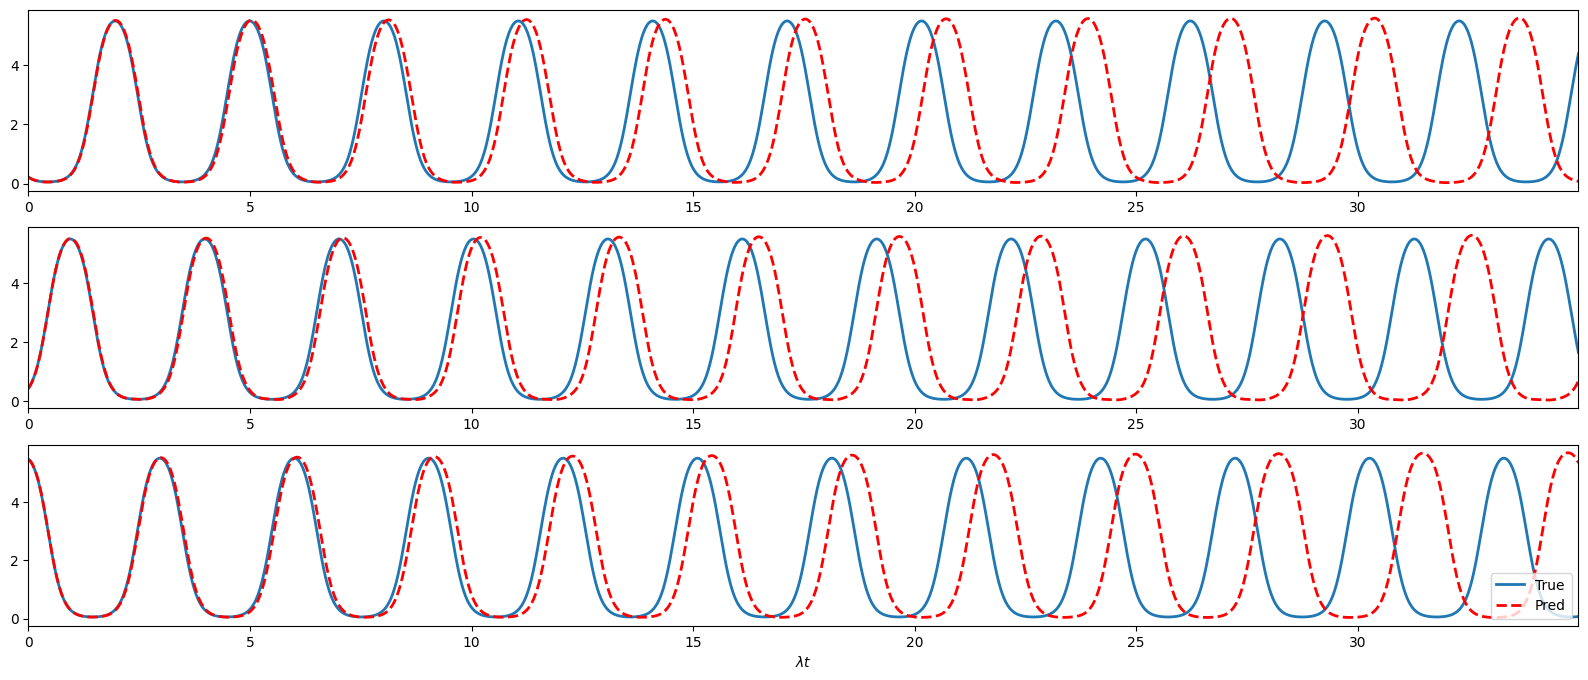

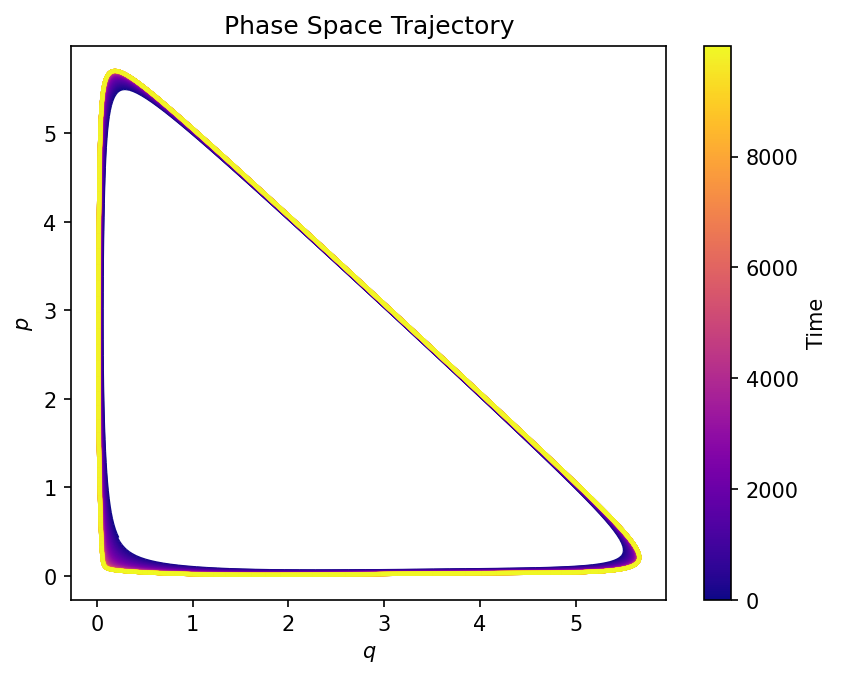

In [46]:
RC = perc.ReservoirComputer(**RC_CONFIG)
_ = RC.train(U_train)
U_pred = RC.forecast(FCAST_LEN)

C_err_uc = (C@U_pred - d).reshape(-1)[:U_test.shape[1]]

vis.plot_time_series_pred(
    U_test,
    U_pred[:,:U_test.shape[1]],
    t_test
)

vis.plot_phase_space(U_pred[:2,:])

# Train Constrained RC

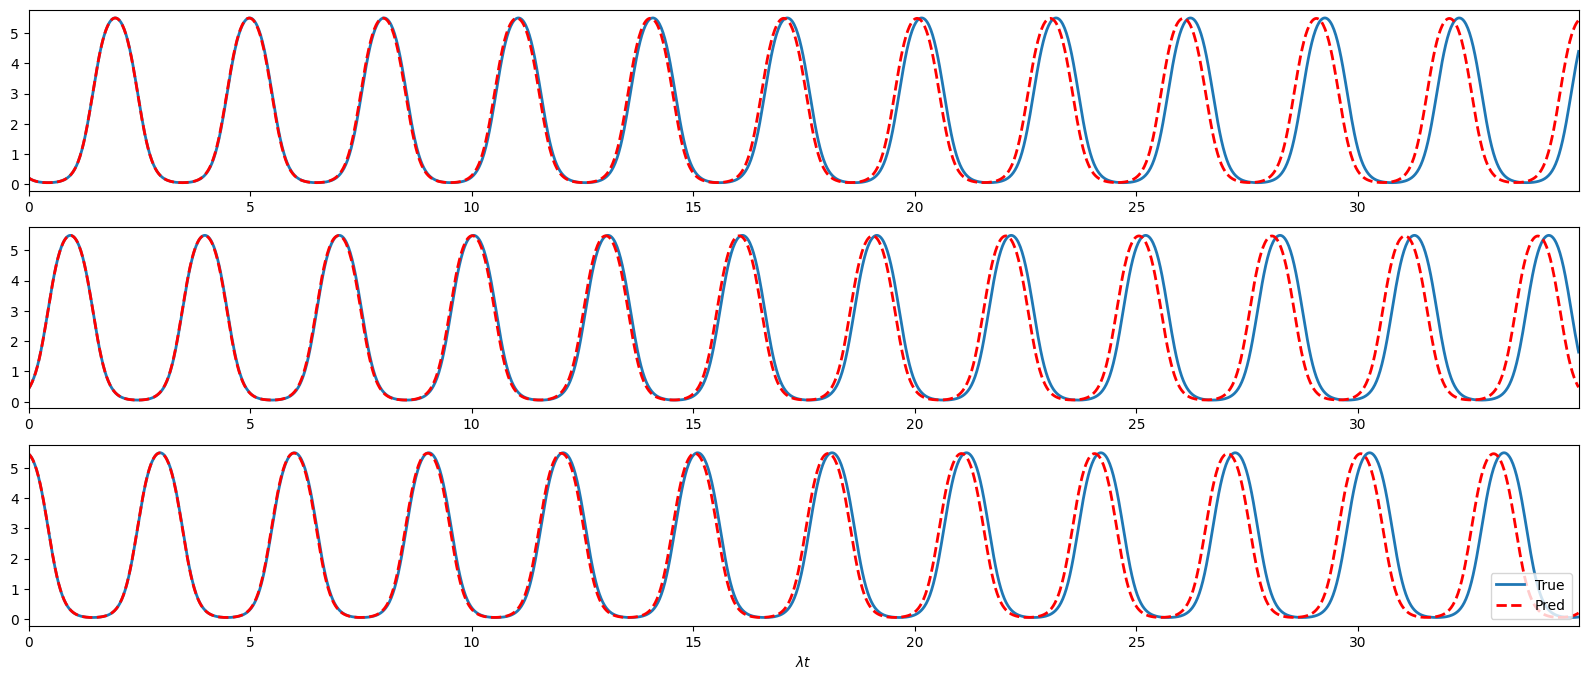

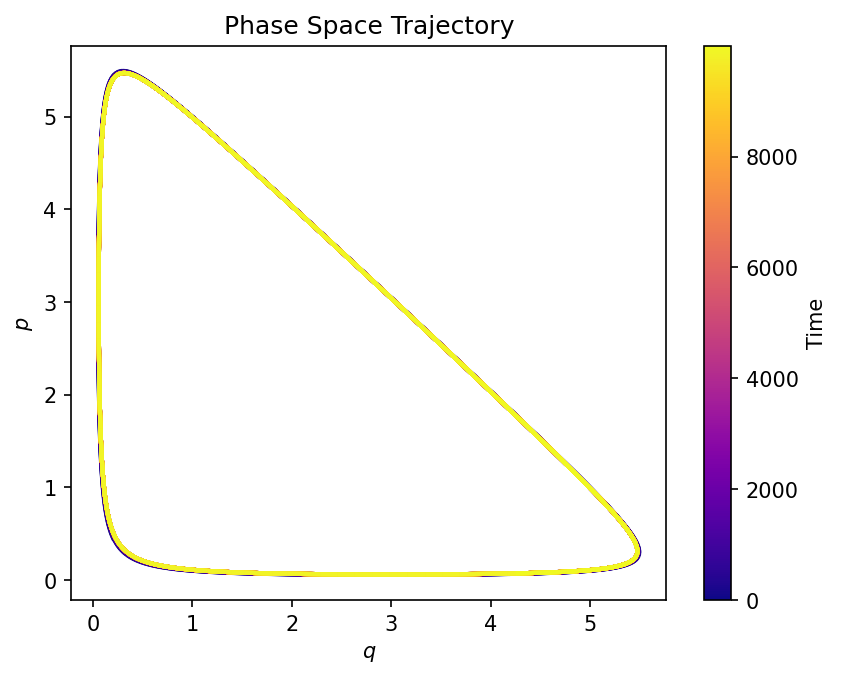

In [47]:
### Train Constrained RC ###
RC = perc.ReservoirComputer(**RC_CONFIG)
_ = RC.train_lih(U_train,C,d,
                     solver = cp.CLARABEL,
                     warm_start = True)
U_pred = RC.forecast_lih(FCAST_LEN)[:-1,:]

C_err_c = (C@U_pred - d).reshape(-1)[:U_test.shape[1]]

vis.plot_time_series_pred(
    U_test,
    U_pred[:,:U_test.shape[1]],
    t_test
)

vis.plot_phase_space(U_pred[:2,:])

# Compare Errors 

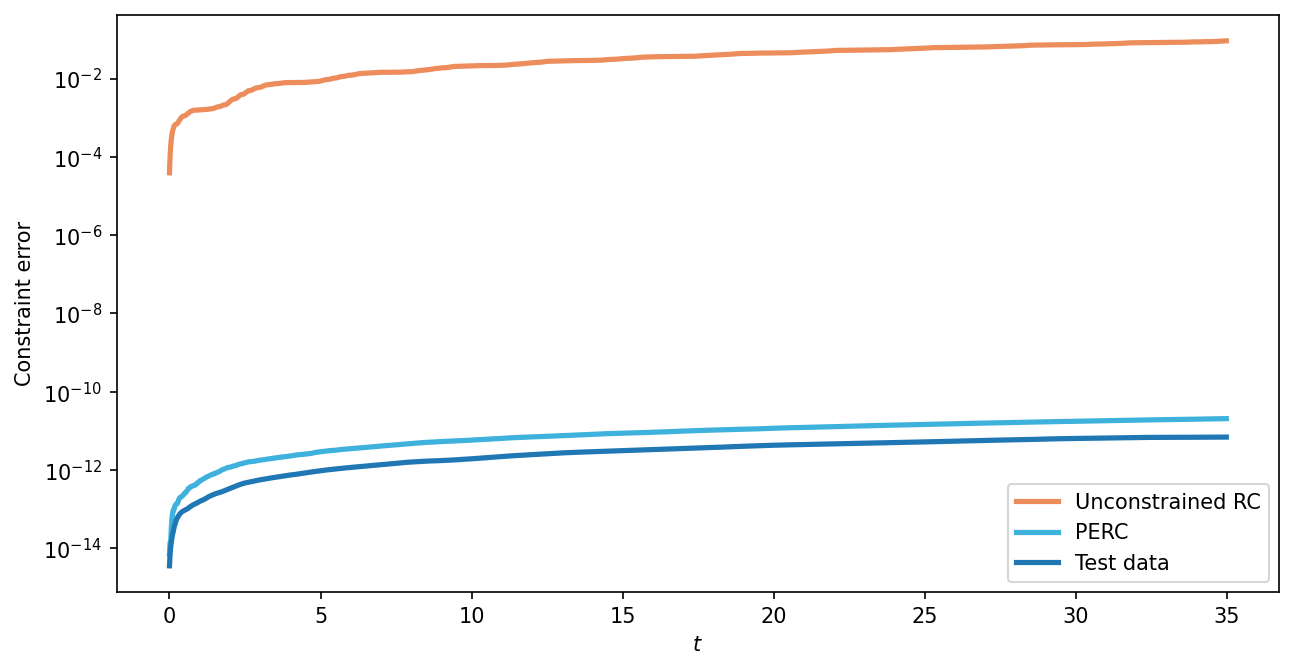

In [48]:
# make err cumulative
C_err_utest = np.cumsum(np.abs(C_err_utest))
C_err_uc = np.cumsum(np.abs(C_err_uc))
C_err_c = np.cumsum(np.abs(C_err_c))

# plot
lw = 2.5
UCRC_color = "#ed8d5b"
PERC_color = "#3fb1dd"
plt.figure(figsize=(10,5), dpi=150)
plt.plot(t_test, C_err_uc, label = 'Unconstrained RC', linewidth=lw, color=UCRC_color)
plt.plot(t_test, C_err_c, label = 'PERC', linewidth=lw, color=PERC_color)
plt.plot(t_test, C_err_utest, label = 'Test data', linewidth=lw)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel('Constraint error')
plt.show()